##Preprocessing the Data

In [0]:
import fastai
from fastai.text import *

In [0]:
folder = '.'
url = 'https://raw.githubusercontent.com/micklwl/cs3244/master/dataset.csv'
train = pd.read_csv(url, sep =',')

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
train[['Insult', 'Comment']].to_csv('train_final.csv', index=None, header=True)

In [0]:
test = pd.read_csv('../content/gdrive/My Drive/CS3244 Project/Local Data - Sheet1.csv')

In [0]:
#Convert contractions
def preprocess(dataset):
  dataset["Comment"] = dataset["Comment"].str.replace("can't","can not")
  dataset["Comment"] = dataset["Comment"].str.replace("you're","you are")
  dataset["Comment"] = dataset["Comment"].str.replace("don't","do not")
  dataset["Comment"] = dataset["Comment"].str.replace("i'm","i am")

  return dataset

In [0]:
preprocess(test)

,Insult,Comment
0,0,Sad truth is there are more hot girls than suc...
1,1,"To the author, you should just contract covid ..."
2,0,Aiyo it's just diff cultures la..china men are...
3,0,Korean oppa seem to cry alot too. Maybe he tho...
4,0,Guess all the mid range height population are ...
...,...,...
295,0,Yes. You will need to wear a mask.
296,1,"Kbkb, erection still retain power. You guys re..."
297,1,TS do not need brain if not using right?
298,1,Circuit breaker really accelerate their mental...


In [0]:
test[['Insult','Comment']].to_csv('test.csv', index=None, header=True)

In [0]:
# Local Data
test_file = 'test.csv'

In [0]:
# For the language model
train['Comment'].to_csv('unlabeled_comments.csv', index=None, header=True)

In [0]:
folder = '.'
unlabeled_file = 'unlabeled_comments.csv'

In [0]:
bs,bptt=32,80

##Fine-tuning the Language Model

In [0]:
# Tokenize data for the language model
data_lm = TextLMDataBunch.from_csv(folder, unlabeled_file, text_cols='Comment')

In [0]:
# Saves the data, so that when the notebook is restarted, 
# we don't have to run data_lm again
data_lm.save('data_lm.pkl')

In [0]:
# Loads data
data_lm = load_data(folder, 'data_lm.pkl', bs=bs, bptt=bptt)

In [0]:
data_lm.show_batch()

idx,text
0,the premise of the article is not that jesus existed it is that a time and place existed that jesus was placed in 2005 6 nov 2004 utc xxbos multiple mainstreams for the authors preferred minority view and single mainstream for the authors personally disliked minority view shall we open another rfc and switch it around no that would be transparently disingenuous would nt it did the closer even read
1,though i am sure some of them do deserve their own pages already xxbos haha yea i think she was complaining about being fat because she is now 108 or something like that xxbos dubious i have a feeling that the examples destiny xxunk or xxunk master of illusions are inaccurate and may also spark a contradiction where it says the the pokemon movies are rated g while destiny xxunk
2,article with no content whatsoever or whose contents consist only of external links see also section book reference category tag template tag interwiki link rephrasing of the title or an attempt to contact the subject of the article please see wikipediastub for our minimum information standards for short articles also please note that articles must be on notable subjects and should provide references to reliable sources that verify their content
3,but better is very subjective and i am strictly speaking from an objective point of view ok just so were on the same page ill reword my argument as best i can for i am pretty tired so we can stop going in circles wikipedia is a database of information and as a database and also an encyclopedia there must be a standard setting language consolidation unification etc so that
4,can not fix it i have found errors in the page title name of author name of website and year why is it wrong to fix such things xxbos dmsg again the reference to the dmsg deutsche multiple xxunk xxunk is problematic its a primary source is it independent from what organizations form as patient organizations often but as they develop they find sources of funding often from drug companies


In [0]:
# Create the language model using the tokenized data
learn = language_model_learner(data_lm, AWD_LSTM)

In [0]:
# Finds the best learning rate for fine-tuning the language model
%%time
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
CPU times: user 10.7 s, sys: 5.96 s, total: 16.6 s
Wall time: 16.9 s


Min numerical gradient: 1.58E-02
Min loss divided by 10: 1.20E-02


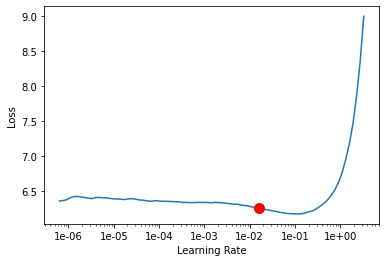

In [0]:
learn.recorder.plot(suggestion=True)

In [0]:
# Retrieves the best learning rate for the language model
best_lm_lr = learn.recorder.min_grad_lr
best_lm_lr

0.01584893192461114

In [0]:
# Learning with Discriminative fine-tuning and gradual unfreezing
learn.fit_one_cycle(1, best_lm_lr, moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,5.337577,4.972857,0.219481,09:40


In [0]:
learn.unfreeze()

In [0]:
%%time
learn.fit_one_cycle(1, best_lm_lr/10, moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,4.882156,4.636635,0.255899,09:47


CPU times: user 6min 10s, sys: 3min 30s, total: 9min 40s
Wall time: 9min 47s


In [0]:
learn.save_encoder('fwd_enc')

In [0]:
learn = language_model_learner(data_bwd, AWD_LSTM)

In [0]:
%%time
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
CPU times: user 10.9 s, sys: 6.15 s, total: 17 s
Wall time: 17.3 s


Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.45E-02


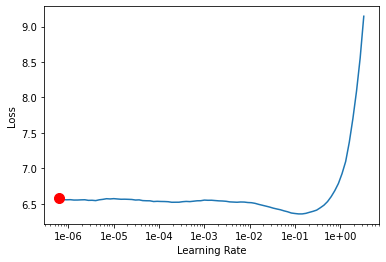

In [0]:
learn.recorder.plot(suggestion=True)

In [0]:
best_lm_lr_bwd = learn.recorder.min_grad_lr
best_lm_lr_bwd

6.309573444801933e-07

In [0]:
learn.fit_one_cycle(1, best_lm_lr_bwd, moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,6.563960,6.160361,0.152435,09:40


In [0]:
learn.unfreeze()

In [0]:
%%time
learn.fit_one_cycle(1, best_lm_lr_bwd/10, moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,6.489982,6.119253,0.154396,09:46


CPU times: user 6min 9s, sys: 3min 31s, total: 9min 40s
Wall time: 9min 46s


In [0]:
learn.save_encoder('bwd_enc')

##Fine-tuning the Classifier

In [0]:
data_clas_local = TextClasDataBunch.from_csv(path=folder, 
                                        csv_name=test_file,
                                        vocab=data_lm.train_ds.vocab, 
                                        bs=32,
                                        text_cols='Comment', 
                                        label_cols='Insult')

In [0]:
data_clas_local.show_batch()

text,target
xxbos xxmaj xxunk it xxunk just diff cultures la xxunk china men are known to spoil their xxunk and spend money on them like water like that xxunk xxunk they are literally brought up that way lol xxunk xxunk xxunk tbh if he is not spending xxunk on you despite his high salary xxunk why not u just communicate what u want xxunk xxunk xxunk why u want to post,0
xxbos i do agree the xxup lta officer acted in a professional way xxunk but who confronted who in the first place xxunk xxup lta said the delivery rider confronted the xxup lta officer xxunk was that so xxunk xxunk xxmaj if the rider has been smoking in a non xxunk prohibited place xxunk why did the officer confront the rider xxunk xxmaj does xxunk he know how to put,0
xxbos xxmaj you do nt be so xxunk xxmaj xxunk can or not xxunk xxunk xxmaj inhale cigarette then put on mask on and off xxunk xxunk xxmaj your xxunk common sense teach u is it xxunk u want rider to dye from smoking is it xxunk xxmaj damn xxunk people think this way is it xxunk xxmaj if xxunk and those exercise can have priviledge not wearing mask then,1
xxbos xxmaj kudos to xxup lta enforcement officer xxunk cool and composed xxunk you must know your work very well xxunk you understand and calm each and everyone hearing your good advise xxunk xxunk xxmaj you did xxunk realised monkey is recording you too xxunk cause only small dd donkey do monkey business xxunk if you know what i mean xxunk xxmaj do xxunk be disheartened xxunk you are doing,1
xxbos xxmaj the virus do xxunk give a crap whether or not u r xxunk or xxmaj singaporean xxmaj that is why the world should unite xxunk xxmaj there is nothing anti xxunk china xxunk xxmaj there is nothing anti xxunk chinese xxunk xxmaj the correct attitude is to avoid ccp killing people in xxmaj china and outside xxmaj china the 3rd xxunk the 4th time and so on xxunk,0


In [0]:
data_clas_local.save('data_clas_local.pkl')

In [0]:
data_clas_local = load_data(folder, 'data_clas_local.pkl', bs=bs)

In [0]:
data_clas_local_bwd = load_data(folder, 'data_clas_local.pkl', bs=bs, backwards=True)

In [0]:
data_clas_local_bwd.show_batch()

text,target
pls communicate xxup just xxup xxunk la wrong or right no is there xxunk xxunk xxunk people mature like it about communicate can all xxunk then something for up saving is he unless xxunk xxunk xxunk means monetary the has he since it do and ahead go xxunk he sure xxunk i xxunk happy u makes u for bag chanel xxmaj a buying if xxmaj xxunk right expectations your communicate,0
xxunk otherwise thinks eyes public the of members but xxunk wrong nothing did he when officers enforcement many so by confronted being for upset very be must rider this xxmaj xxunk mistake the for apologies officer the not can why xxunk smoking was he while mask a on putting not for rider the mistaken has officer lta xxup the if xxmaj xxunk made was offence no though even you confronted,0
xxunk ok xxup n 7 xxrep i 4 xxrep bra xxup your xxup use xxup xxunk brain xxup your xxup use xxup so xxup xxunk mosquitoes kill like around air bad kill to help knows who xxunk like is smoke the xxunk only minutes 15 or 10 only not can smoker why then mask wearing not priviledge have can exercise those and xxunk if xxmaj xxunk it is way this,1
xxunk me on tea bubbles and xxunk done well xxmaj xxunk xxunk you see i whenever you salute will i and xxunk you xxmaj salute xxmaj i xxunk this with xxmaj xxunk now needed most country xxmaj the which xxunk went you xxmaj xxunk sun hot under job great a doing are you xxunk disheartened be xxunk do xxmaj xxunk mean i what know you if xxunk business monkey do,1
hands your in blood have xxunk should u why is that and xxunk ones closed our be can it and die can anyone xxunk xxmaj xxunk on so and time 4th the xxunk 3rd the china xxmaj outside and china xxmaj in people killing ccp avoid to is attitude correct the xxmaj xxunk chinese xxunk anti nothing is there xxmaj xxunk china xxunk anti nothing is there xxmaj xxunk unite,0


In [0]:
learn_clas_local = text_classifier_learner(data_clas_local, AWD_LSTM, drop_mult=0.5, pretrained=False)
learn_clas_local.load_encoder('fwd_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (239 items)
x: TextList
xxbos xxmaj she video it to find any possibility to win xxunk xxunk xxunk so stupid to use such skill and waste of everyone time at this moment xxunk,xxbos xxmaj must put on mask when talking and taking video la xxunk xxunk xxmaj we do not see anyone smoking in this video la xxunk,xxbos i xxmaj am christian but the sex xxmaj is xxmaj so good xxunk,xxbos xxunk erm xxunk you do not sound like you have a problem xxunk so why are you posting here xxunk xxmaj or my reading comprehension fail xxunk xxunk,xxbos xxmaj foreign xxmaj workers got infected totally due to fault of locals xxunk xxmaj these workers got infected due to careless behaviour of locals xxunk
y: CategoryList
1,1,1,1,0
Path: .;

Valid: LabelList (61 items)
x: TextList
xxbos xxmaj err f off la xxunk xxmaj nobody need u to comment,xxbos xxmaj like an entitled whore xxunk xxmaj all these xxmaj generals want to show good xxunk so that can pay millions t

In [0]:
learn_clas_local.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.63E-03
Min loss divided by 10: 1.74E-02


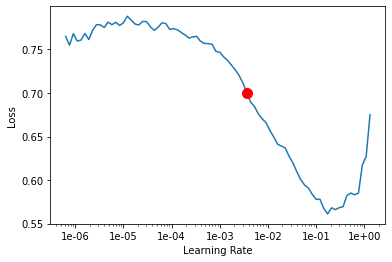

In [0]:
learn_clas_local.recorder.plot(suggestion=True)

In [0]:
best_clf_lr_local = learn_clas_local.recorder.min_grad_lr
best_clf_lr_local

0.00363078054770101

In [0]:
learn_clas_local.fit_one_cycle(1, best_clf_lr_local, moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.744087,0.669639,0.557377,00:00


In [0]:
learn_clas_local.freeze_to(-2)
best_clf_lr_local /= 2
learn_clas_local.fit_one_cycle(1, slice(best_clf_lr_local/(2.6**4),best_clf_lr_local), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.525292,0.670863,0.590164,00:00


In [0]:
learn_clas_local.freeze_to(-3)
best_clf_lr_local /= 2
learn_clas_local.fit_one_cycle(1, slice(best_clf_lr_local/(2.6**4),best_clf_lr_local), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.435292,0.659859,0.606557,00:00


In [0]:
learn_clas_local.unfreeze()
best_clf_lr_local /= 5
learn_clas_local.fit_one_cycle(1, slice(best_clf_lr_local/(2.6**4),best_clf_lr_local), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.401153,0.658436,0.639344,00:00


In [0]:
learn_clas_local.save('fwd_clas')

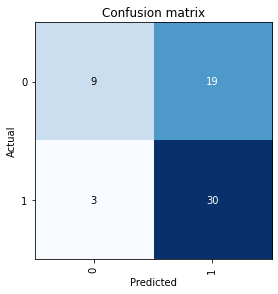

In [0]:
preds,y,losses = learn_clas_local.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn_clas_local, preds, y, losses)
interp.plot_confusion_matrix()

In [0]:
learn_clas_local_bwd = text_classifier_learner(data_clas_local, AWD_LSTM, drop_mult=0.5, pretrained=False)
learn_clas_local_bwd.load_encoder('bwd_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (239 items)
x: TextList
xxbos xxmaj she video it to find any possibility to win xxunk xxunk xxunk so stupid to use such skill and waste of everyone time at this moment xxunk,xxbos xxmaj must put on mask when talking and taking video la xxunk xxunk xxmaj we do not see anyone smoking in this video la xxunk,xxbos i xxmaj am christian but the sex xxmaj is xxmaj so good xxunk,xxbos xxunk erm xxunk you do not sound like you have a problem xxunk so why are you posting here xxunk xxmaj or my reading comprehension fail xxunk xxunk,xxbos xxmaj foreign xxmaj workers got infected totally due to fault of locals xxunk xxmaj these workers got infected due to careless behaviour of locals xxunk
y: CategoryList
1,1,1,1,0
Path: .;

Valid: LabelList (61 items)
x: TextList
xxbos xxmaj err f off la xxunk xxmaj nobody need u to comment,xxbos xxmaj like an entitled whore xxunk xxmaj all these xxmaj generals want to show good xxunk so that can pay millions t

In [0]:
learn_clas_local_bwd.fit_one_cycle(1, best_clf_lr_local, moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.811737,0.717934,0.459016,00:00


In [0]:
learn_clas_local_bwd.freeze_to(-2)
best_clf_lr_local /= 2
learn_clas_local_bwd.fit_one_cycle(1, slice(best_clf_lr_local/(2.6**4),best_clf_lr_local), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.765353,0.757650,0.459016,00:00


In [0]:
learn_clas_local_bwd.freeze_to(-3)
best_clf_lr_local /= 2
learn_clas_local_bwd.fit_one_cycle(1, slice(best_clf_lr_local/(2.6**4),best_clf_lr_local), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.736453,0.792628,0.459016,00:00


In [0]:
learn_clas_local_bwd.unfreeze()
best_clf_lr_local /= 5
learn_clas_local_bwd.fit_one_cycle(1, slice(best_clf_lr_local/(2.6**4),best_clf_lr_local), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.695739,0.805667,0.459016,00:00


In [0]:
learn_clas_local_bwd.save('bwd_clas')

##Analyse the Results

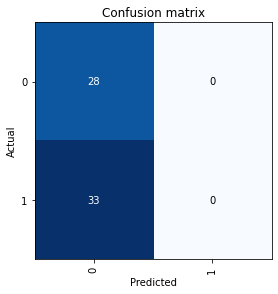

In [0]:
preds,y,losses = learn_clas_local_bwd.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn_clas_local_bwd, preds, y, losses)
interp.plot_confusion_matrix()

In [0]:
pred_fwd,lbl_fwd = learn_clas_local.get_preds(ordered=True)

In [0]:
pred_bwd,lbl_bwd = learn_clas_local_bwd.get_preds(ordered=True)

In [0]:
final_pred = (pred_fwd+pred_bwd)/2

In [0]:
accuracy(final_pred, lbl_fwd)

tensor(0.4918)

In [0]:
accuracy(final_pred, lbl_bwd)

tensor(0.4918)

In [0]:
learn_clas_local.predict("fuck you chee bai")

(Category 1, tensor(1), tensor([0.1858, 0.8142]))

In [0]:
learn_clas_local.predict("i hope you jump off the cliff and die")

(Category 1, tensor(1), tensor([0.1751, 0.8249]))

In [0]:
learn_clas_local.predict("i hope you have a good day!")

(Category 1, tensor(1), tensor([0.4281, 0.5719]))

In [0]:
learn_clas_local.predict("kanasai")

(Category 1, tensor(1), tensor([0.4071, 0.5929]))

In [0]:
recall(final_pred, lbl_fwd)

Couldn't evaluate or find in history: (final_pred, lbl_fwd)


In [0]:
accuracy(final_pred, lbl_bwd)

tensor(0.4918)

In [0]:
learn_clas_local_bwd1 = text_classifier_learner(data_clas_local, AWD_LSTM, drop_mult=0.5, pretrained=False)
learn_clas_local_bwd1.load_encoder('bwd_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (239 items)
x: TextList
xxbos xxmaj she video it to find any possibility to win xxunk xxunk xxunk so stupid to use such skill and waste of everyone time at this moment xxunk,xxbos xxmaj must put on mask when talking and taking video la xxunk xxunk xxmaj we do not see anyone smoking in this video la xxunk,xxbos i xxmaj am christian but the sex xxmaj is xxmaj so good xxunk,xxbos xxunk erm xxunk you do not sound like you have a problem xxunk so why are you posting here xxunk xxmaj or my reading comprehension fail xxunk xxunk,xxbos xxmaj foreign xxmaj workers got infected totally due to fault of locals xxunk xxmaj these workers got infected due to careless behaviour of locals xxunk
y: CategoryList
1,1,1,1,0
Path: .;

Valid: LabelList (61 items)
x: TextList
xxbos xxmaj err f off la xxunk xxmaj nobody need u to comment,xxbos xxmaj like an entitled whore xxunk xxmaj all these xxmaj generals want to show good xxunk so that can pay millions t

In [0]:
learn_clas_local_bwd1.fit_one_cycle(1, best_clf_lr_local, moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.766022,0.685138,0.540984,00:00


In [0]:
learn_clas_local_bwd1.freeze_to(-2)
best_clf_lr_local /= 2
learn_clas_local_bwd1.fit_one_cycle(1, slice(best_clf_lr_local/(2.6**4),best_clf_lr_local), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.773216,0.682804,0.540984,00:00


In [0]:
learn_clas_local_bwd1.freeze_to(-3)
best_clf_lr_local /= 2
learn_clas_local_bwd1.fit_one_cycle(1, slice(best_clf_lr_local/(2.6**4),best_clf_lr_local), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.794282,0.678283,0.524590,00:00


In [0]:
learn_clas_local_bwd1.unfreeze()
best_clf_lr_local /= 5
learn_clas_local_bwd1.fit_one_cycle(1, slice(best_clf_lr_local/(2.6**4),best_clf_lr_local), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.756245,0.674884,0.622951,00:00


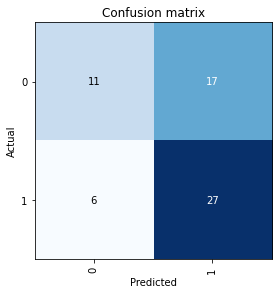

In [0]:
preds,y,losses = learn_clas_local_bwd1.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn_clas_local_bwd1, preds, y, losses)
interp.plot_confusion_matrix()

In [0]:
pred_fwd,lbl_fwd = learn_clas_local.get_preds(ordered=True)

In [0]:
pred_bwd,lbl_bwd = learn_clas_local_bwd1.get_preds(ordered=True)

In [0]:
final_pred = (pred_fwd+pred_bwd)/2

In [0]:
accuracy(final_pred, lbl_fwd)

tensor(0.5902)

In [0]:
learn_clas_local_bwd1.predict("you cb")

(Category 1, tensor(1), tensor([0.4780, 0.5220]))

In [0]:
learn_clas_local_bwd1.predict("kanasai")

(Category 0, tensor(0), tensor([0.5798, 0.4202]))